In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import random

In [18]:
data_dir = 'C:\\Users\\muham\\Desktop\\jupyter\\Agricultural-crops'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
classes = dataset.classes

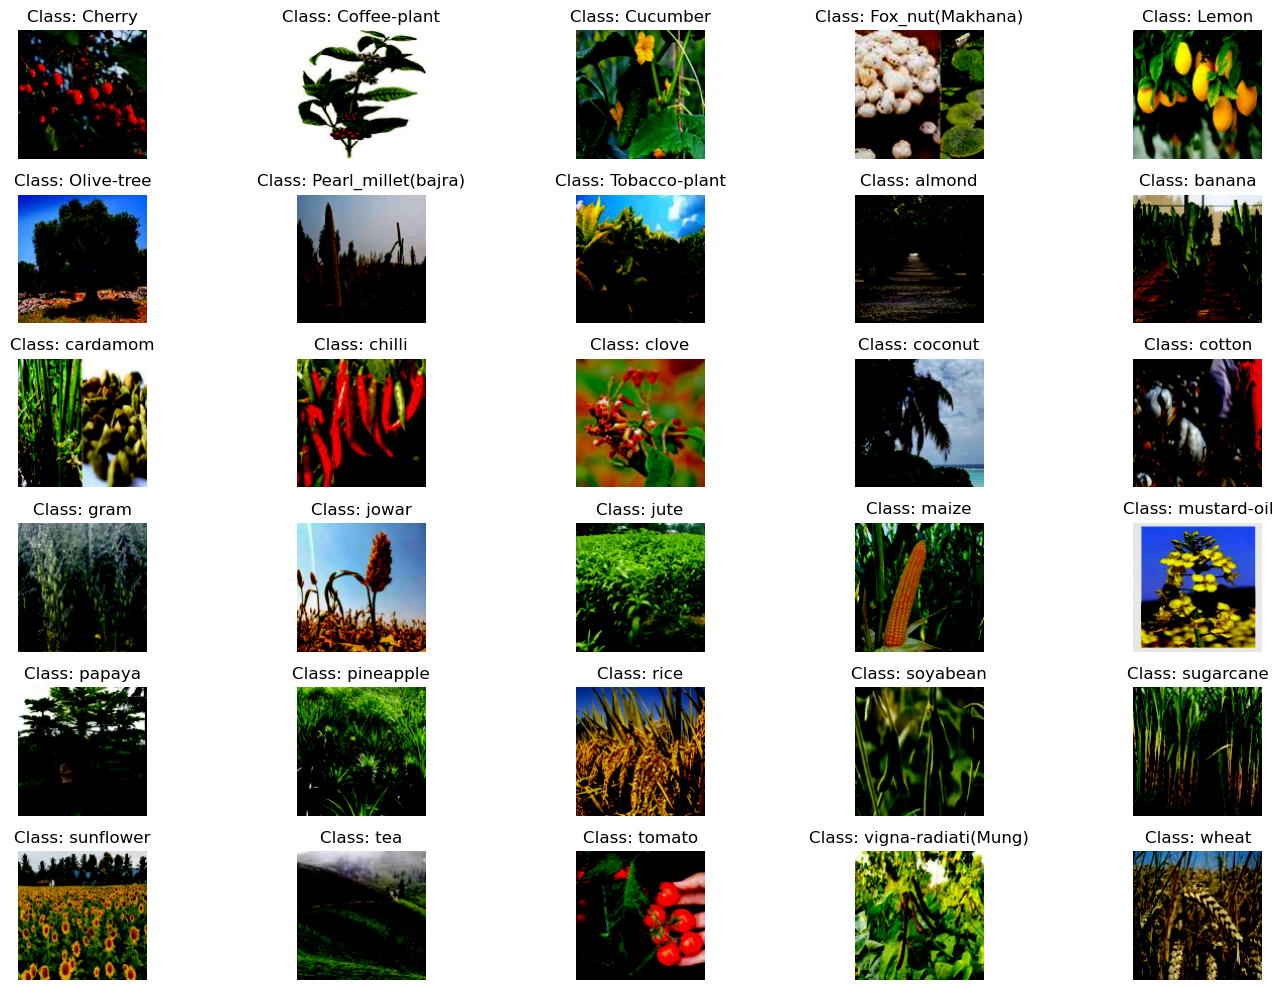

In [24]:
classes = dataset.classes

num_classes = len(classes)
num_rows = num_classes // 5  
num_cols = 5


plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    class_indices = dataset.targets.index(i)
    image, _ = dataset[class_indices]
    image = image.clamp(0, 1)  
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image.permute(1, 2, 0))  
    plt.title(f"Class: {class_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [25]:
# Task 2 
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
# Task 3
class NetSigmoid(nn.Module):
    def __init__(self, num_classes):
        super(NetSigmoid, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.sigmoid(self.conv1(x)))
        x = self.pool(torch.sigmoid(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

In [27]:
# Task 4
def weights_init_small_random(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)

# Xavier initialization
def weights_init_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


net_small_random = Net(num_classes)
net_small_random.apply(weights_init_small_random)

net_xavier = Net(num_classes)
net_xavier.apply(weights_init_xavier)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=30, bias=True)
)

In [28]:
class NetWithDropout(nn.Module):
    def __init__(self, num_classes):
        super(NetWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [29]:
class NetWithBatchNorm(nn.Module):
    def __init__(self, num_classes):
        super(NetWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [30]:
def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_loss.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return train_loss

In [31]:
def evaluate_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

Training ReLU + Random Init
Epoch [1/10], Loss: 4.0222
Epoch [2/10], Loss: 3.3819
Epoch [3/10], Loss: 3.2029
Epoch [4/10], Loss: 2.8872
Epoch [5/10], Loss: 2.5258
Epoch [6/10], Loss: 2.0789
Epoch [7/10], Loss: 1.4817
Epoch [8/10], Loss: 1.0691
Epoch [9/10], Loss: 0.5176
Epoch [10/10], Loss: 0.3104
Accuracy of ReLU + Random Init: 27.71%
Training Sigmoid + Random Init
Epoch [1/10], Loss: 3.6323
Epoch [2/10], Loss: 3.4698
Epoch [3/10], Loss: 3.4585
Epoch [4/10], Loss: 3.4455
Epoch [5/10], Loss: 3.4508
Epoch [6/10], Loss: 3.4536
Epoch [7/10], Loss: 3.4396
Epoch [8/10], Loss: 3.4341
Epoch [9/10], Loss: 3.4485
Epoch [10/10], Loss: 3.4480
Accuracy of Sigmoid + Random Init: 1.81%
Training ReLU + Dropout
Epoch [1/10], Loss: 3.5942
Epoch [2/10], Loss: 3.1943
Epoch [3/10], Loss: 2.6960
Epoch [4/10], Loss: 2.0479
Epoch [5/10], Loss: 1.4463
Epoch [6/10], Loss: 0.9535
Epoch [7/10], Loss: 0.6840
Epoch [8/10], Loss: 0.4443
Epoch [9/10], Loss: 0.2302
Epoch [10/10], Loss: 0.1812
Accuracy of ReLU + Dropo

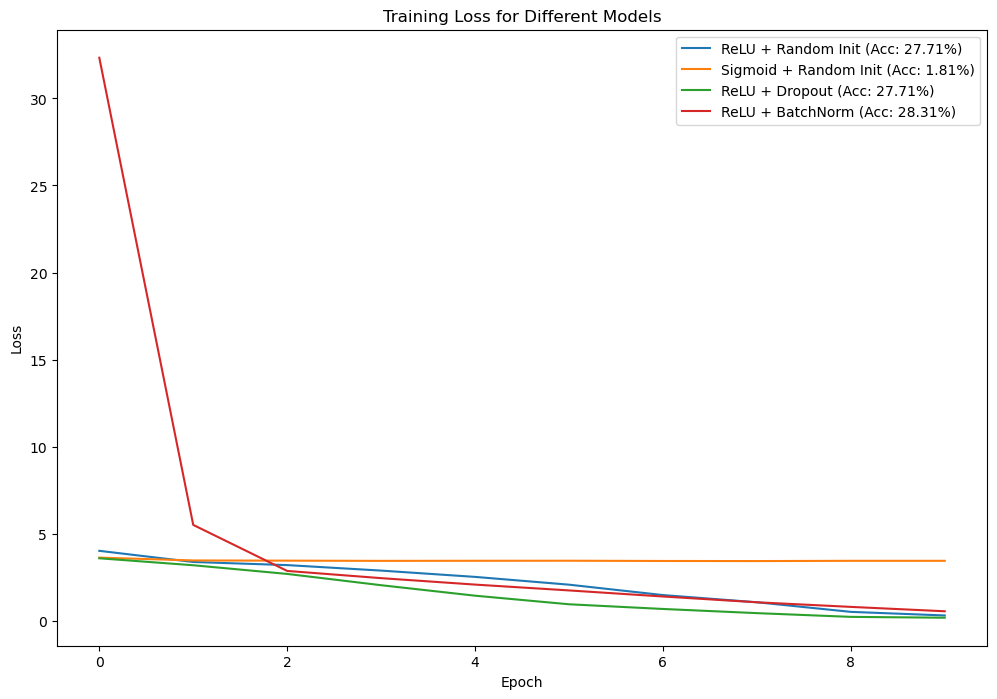

In [33]:
models = {
    "ReLU + Random Init": Net(num_classes),
    "Sigmoid + Random Init": NetSigmoid(num_classes),
    "ReLU + Dropout": NetWithDropout(num_classes),
    "ReLU + BatchNorm": NetWithBatchNorm(num_classes),
}

criteria = nn.CrossEntropyLoss()
num_epochs = 10
results = {}

for name, model in models.items():
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f'Training {name}')
    train_loss = train_model(model, criteria, optimizer, num_epochs)
    accuracy = evaluate_model(model)
    results[name] = {
        'train_loss': train_loss,
        'accuracy': accuracy,
    }
    print(f'Accuracy of {name}: {accuracy:.2f}%')

    
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for name, result in results.items():
    plt.plot(result['train_loss'], label=f'{name} (Acc: {result["accuracy"]:.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Different Models')
plt.legend()
plt.show()
